In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from influxdb import *
import datetime                        
import matplotlib.pyplot as plt                    # plots
import seaborn as sns                              # more plots
from dateutil.relativedelta import relativedelta   # working with dates with style
from scipy.optimize import minimize                # for function minimization
import statsmodels.formula.api as smf              # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product                      # some useful functions
#from tqdm import tqdm_notebook
%matplotlib inline
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
#from mlxtend.regressor import LinearRegression

In [2]:
data = pd.read_excel (r'C:\Users\u22v09\Desktop\One_hr_agg_Data.xlsx') 
#data=data.set_index('time')

In [3]:
data=data[(data['time']<"2020-06-24 00:00:00") ]
data=data.set_index('time')

In [4]:
Time_range = pd.DataFrame(pd.date_range(start = '2020-06-15 00:00:00', end = '2020-06-24 00:00:00', freq = 'H'))
Time_range = Time_range.rename(columns = {0 : "time"})
Time_range.set_index("time", inplace = True)
# Time_range.tail()

In [5]:
data = data.merge(Time_range,  how = "outer", right_index=True, left_index=True)
data.index.freq = 'H'

In [6]:
data.head(2)

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15 01:00:00,995.0,38.8,0.0,3.6,0.0,0.0,363.0,272.0,0.6,0.0,80.2,49.3


In [7]:
data.tail(2)

,EM1,EM10,EM2,EM22,EM23,EM3,EM4,EM5,EM6,EM7,EM8,EM9
time,,,,,,,,,,,,
2020-06-23 23:00:00,598.0,0.6,0.0,0.0,44.2,0.0,174.0,191.0,0.0,0.1,0.0,0.0
2020-06-24 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
EM4 = data[["EM4"]]

In [9]:
EM4 = EM4.iloc[:-1]

In [10]:
EM4_filled = EM4.fillna(method = "ffill")

In [11]:
EM4_filled.iloc[0] = EM4_filled.iloc[1]
EM4_filled.index.freq = 'H'
EM4_filled.head()

,EM4
time,
2020-06-15 00:00:00,363.0
2020-06-15 01:00:00,363.0
2020-06-15 02:00:00,19.0
2020-06-15 03:00:00,19.0
2020-06-15 04:00:00,270.0


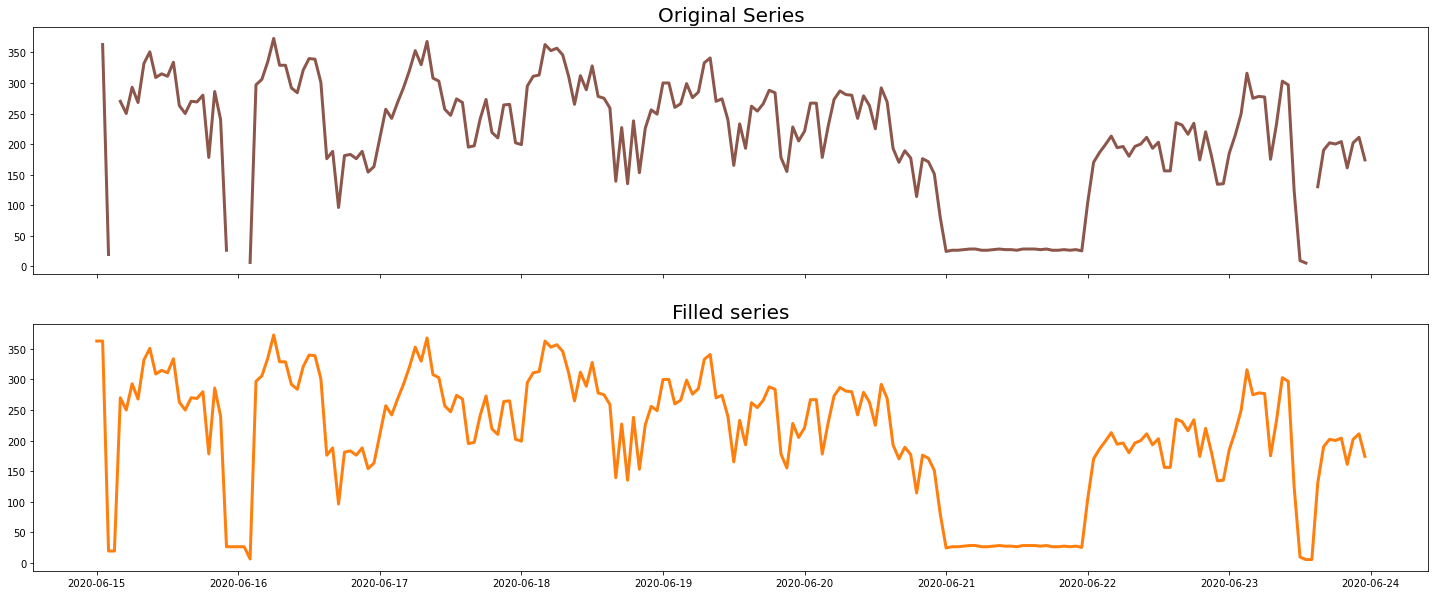

In [12]:
fig, axs = plt.subplots(2, sharex=True, sharey=True, gridspec_kw={'hspace': 0.2}, figsize=(25,10))
# fig.suptitle('Interpolated Series', va = 'bottom', ha = 'center', fontsize = 50)
axs[0].plot(EM4.index, EM4['EM4'], 'tab:brown', linewidth = 3)
axs[0].set_title('Original Series', fontsize = 20)
axs[1].plot(EM4_filled.index, EM4_filled['EM4'], 'tab:orange', linewidth = 3)
axs[1].set_title('Filled series', fontsize = 20)

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(EM4_filled['EM4'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.625814
p-value: 0.000116
Critical Values:
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [14]:
len(EM4_filled)

216

In [15]:
df = EM4_filled.copy()

In [16]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [29]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen = 24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [36]:
%%time
data = df.EM4[:-20] # leave some data for testing
slen = 60

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 5, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0007461510424832118 0.1251937276728372 0.0
Wall time: 1.55 s


In [31]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):

    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-2, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

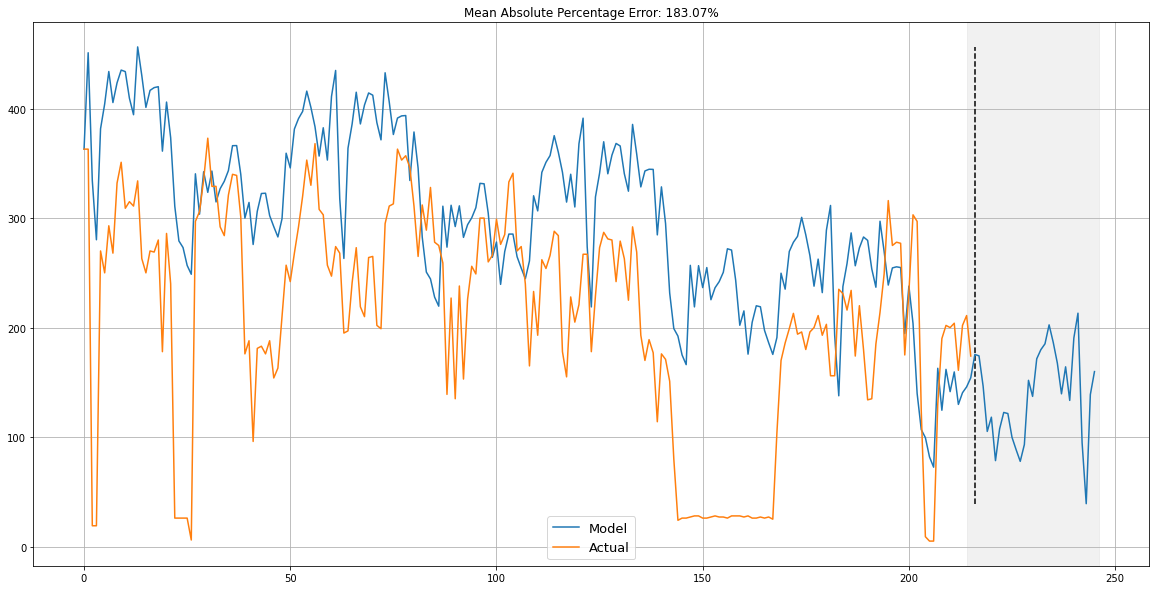

In [32]:
plotHoltWinters(df.EM4)

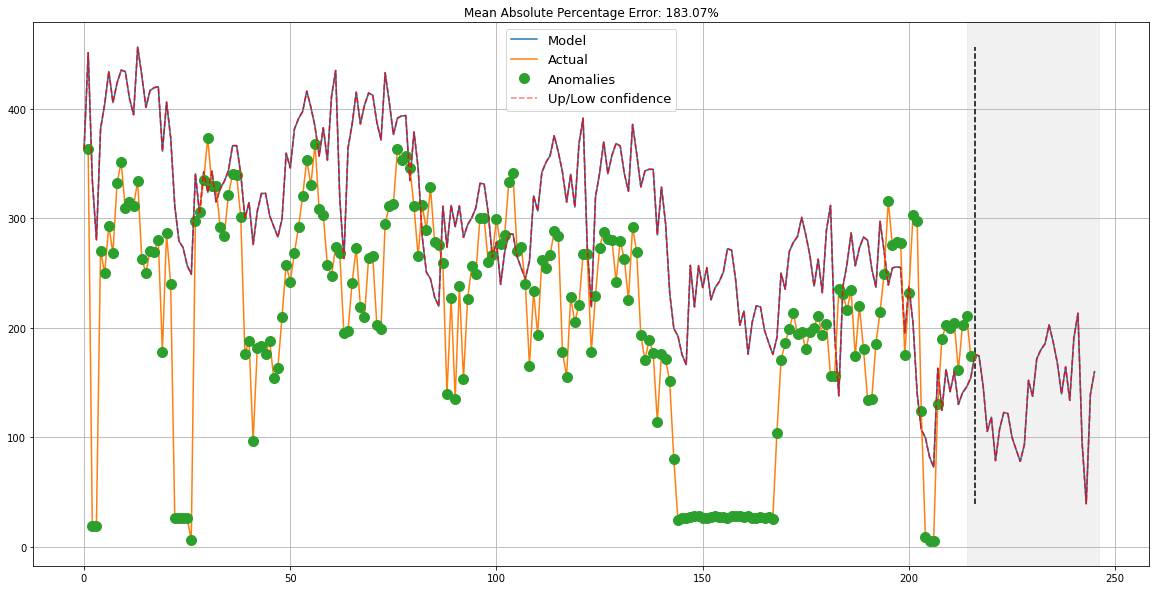

In [33]:
plotHoltWinters(df.EM4, plot_intervals=True, plot_anomalies=True)